## Vehicle Detection

The goals of this project are:
1. Train a classifier to detect vehicles
    * Decide which features to use (e.g. color gradient)
    * use HOG (histogram of gradients)
    * choose and train linear SVM
2. Use the trained classifier on a video stream to detect and track vehicles
    * sliding window scheme

## Fist, define some helper functions for the classifier

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label
from collections import deque
from random import randint

def convert_color(img, conv='YUV'):
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

# Define a function to compute binned color features
def bin_spatial(img, size=(32,32)):
    # Use cv2.resize().ravel() to create the feature vector 
    # features = cv2.resize(img, size).ravel()
    # Return the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    #return features
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the (individiual histograms, bin_centers and) feature vector
    return hist_features

# Define a function to extract features from a list of images 
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0, 
                     spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to 
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        # Apply color_hist() also with a color space option now
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                         orient, pix_per_cell, 
                                                         cell_per_block,
                                                         vis=False, 
                                                         feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell,
                                                cell_per_block, vis=False,
                                                feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
        # Append the new feature vector to the features list
        # features.append(hog_features)
    # Return list of feature vectors
    print('spatial features:', len(spatial_features))
    print('hist features:', len(hist_features))
    print('hog features:', len(hog_features))
    return features      

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys',
                                  transform_sqrt=False,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm='L2-Hys',
                       transform_sqrt=False,
                       visualize=vis, feature_vector=feature_vec)
        return features

## Train Classifier

Load images

Number of car labels:  8792
Number of non-car labels:  8968


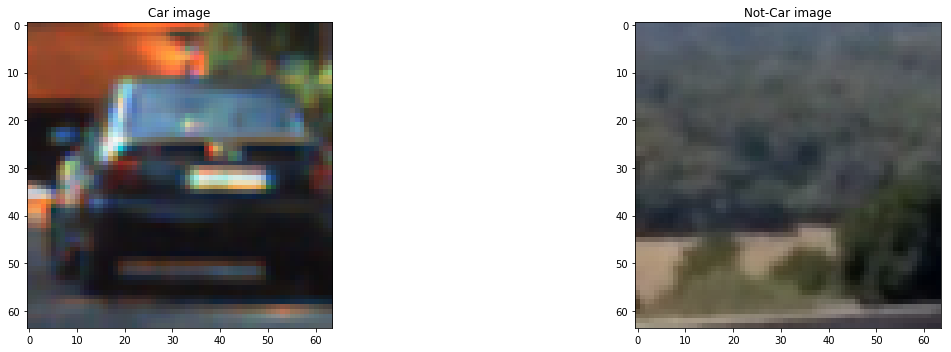

In [22]:
# Read in car and non-car images
cars = glob.glob('./vehicles/vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/non-vehicles/*/*.png')
print('Number of car labels: ', len(cars))
print('Number of non-car labels: ', len(notcars))

fig = plt.figure(figsize=(20, 5))
rand_int = randint(0, len(cars))
car_img = mpimg.imread(cars[rand_int])
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car image')

rand_int = randint(0, len(cars))
notcar_img = mpimg.imread(notcars[rand_int])
plt.subplot(122)
plt.imshow(notcar_img)
plt.title('Not-Car image')
fig.tight_layout()

Create features

In [3]:
# TODO play with these values to see how your classifier 
# performs under different binning scenarios
color_space = 'YUV'
orient = 15 #15 HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) #32 Spatial binning dimensions
hist_bins = 32 #32 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, None] # Min and max in y to search in slide_window()


car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel,
                                   spatial_feat=spatial_feat,
                                   hist_feat=hist_feat,
                                   hog_feat=hog_feat)

spatial features: 3072
hist features: 96
hog features: 8820
spatial features: 3072
hist features: 96
hog features: 8820


Single image example of HOG feature extraction

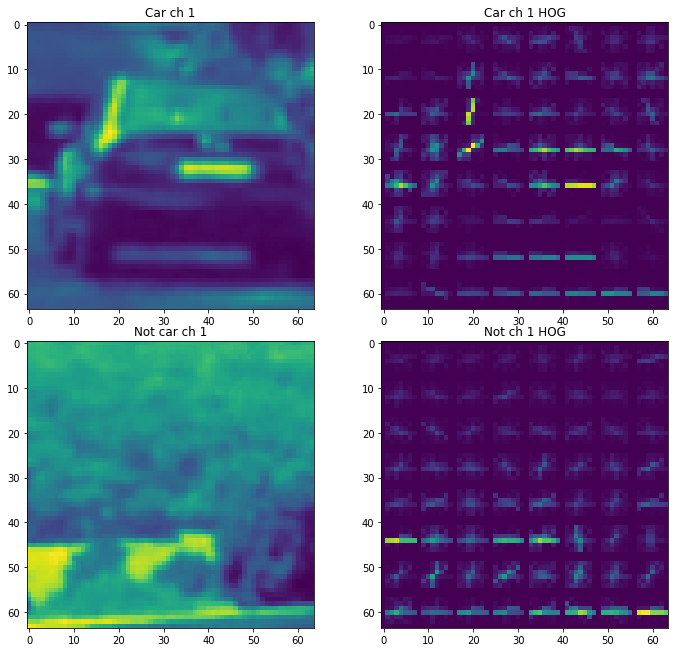

In [46]:
car_imgconv = convert_color(car_img, conv=color_space)
notcar_imgconv = convert_color(notcar_img, conv=color_space)

car_ch1 = car_imgconv[:,:,0]
notcar_ch1 = notcar_imgconv[:,:,0]

car_hogfeat, car_imghog = get_hog_features(car_ch1, orient, 
                                 pix_per_cell, 
                                 cell_per_block,
                                 vis=True, 
                                 feature_vec=True)
notcar_hogfeat, notcar_imghog = get_hog_features(notcar_ch1,
                                     orient, 
                                     pix_per_cell,
                                     cell_per_block,
                                     vis=True,
                                     feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,9))
f.tight_layout()
ax1.imshow(car_ch1)
ax1.set_title('Car ch 1')
ax2.imshow(car_imghog)
ax2.set_title('Car ch 1 HOG')
ax3.imshow(notcar_ch1)
ax3.set_title('Not car ch 1')
ax4.imshow(notcar_imghog)
ax4.set_title('Not ch 1 HOG')

Train classifier

In [4]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(np.shape(X))

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=rand_state)
print(np.shape(X_train))

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test  = X_scaler.transform(X_test)

print('Using:', orient, 'orientations', pix_per_cell, 
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

# Parameter tuning
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svc = svm.SVC()
#clf = GridSearchCV(svc, parameters)
#clf.fit(X_train, y_train)


# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC...')
# Check the score of the SVC
print('Test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict', n_predict, 'labels with SVC')

(17760, 11988)
(14208, 11988)
Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11988
7.24 seconds to train SVC...
Test accuracy of SVC =  0.9913
My SVC predicts:      [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.0025 seconds to predict 10 labels with SVC



## Define some helper functions for the search algorithm

In [5]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB',
                        spatial_size=(32,32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8,
                        cell_per_block=2,
                        hog_channel=0):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)
    #3) Compute spatial feature if flas is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag ist set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append feature to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == "ALL":
            hog_features=[]
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, 
                                                     cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        
    #9) Return concatenated array of features
    return np.concatenate(img_features)
    
    # Append the new feature vector to the features list
    # features.append(np.concatenate((spatial_features, hist_features, hog_features)))
            

# Define a function that takes an image, 
# start and stop position in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], 
                 y_start_stop=[None, None],
                 xy_window=(64,64),
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window position to 
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32,32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, 
                   spatial_feat=True,
                   hist_feat=True, 
                   hog_feat=True):
    img = img.astype(np.float32)/255
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                                       color_space=color_space,
                                       spatial_size=spatial_size,
                                       hist_bins=hist_bins,
                                       orient=orient,
                                       pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1,-1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction==1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), thick)
    # Return the image copy with boxes drawn
    return imcopy


    


# Define a single function that can extract features 
# using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return draw_img, bboxes

def apply_find_cars(img, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(image)
    img = img.astype(np.float32)/255
    
    bboxes = []
    #_, bboxes_part = find_cars(img, 400, 700, 0.7, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bboxes_part)
    _, bboxes_part = find_cars(img, 400, 700, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes_part)
    _, bboxes_part = find_cars(img, 400, 700, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes_part)
    _, bboxes_part = find_cars(img, 400, 700, 1.7, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes_part)
    #_, bboxes_part = find_cars(img, 350, 720, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bboxes_part)
    #_, bboxes_part = find_cars(img, 430, 656, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bboxes_part)
    #_, bboxes_part = find_cars(img, 430, 656, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bboxes_part)
    #_, bboxes_part = find_cars(img, 440, 656, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bboxes_part)
    #_, bboxes_part = find_cars(img, 400, 656, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bboxes_part)
    #_, bboxes_part = find_cars(img, 400, 700, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bboxes_part)
    #_, bboxes_part = find_cars(img, 500, 700, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes.extend(bboxes_part)
    
    out_img = draw_boxes(draw_img, bboxes, color=(0,0,255), thick=3)
    #print(bboxes)
    
    
    
    return out_img, bboxes

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap # Itearte

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def pipeline(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    out_img, bboxes = apply_find_cars(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)
    # Visualize the heatmap when displaying
    heatmap_current = np.clip(heat, 0, 255)
    memory.append(heatmap_current)
    
    heatmap = np.zeros_like(heatmap_current).astype(np.float)
    for heat in memory:
        heatmap += heat
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return out_img, heatmap, draw_img
    


## Search on test images

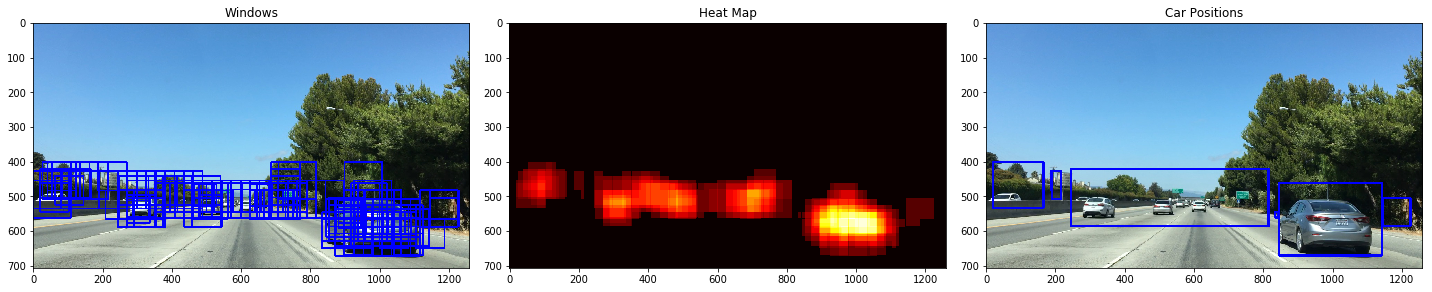

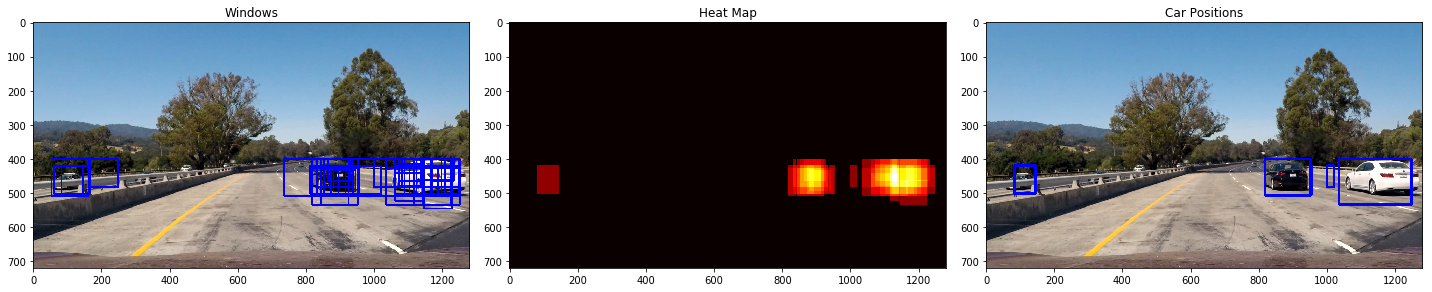

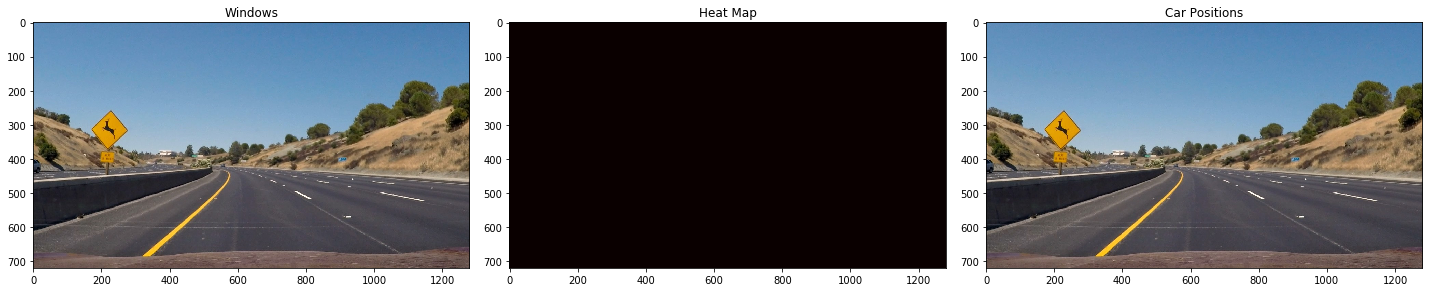

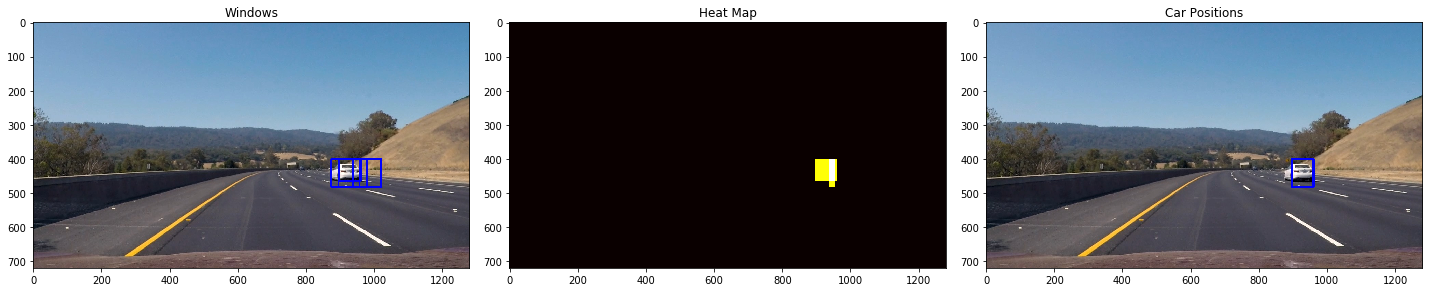

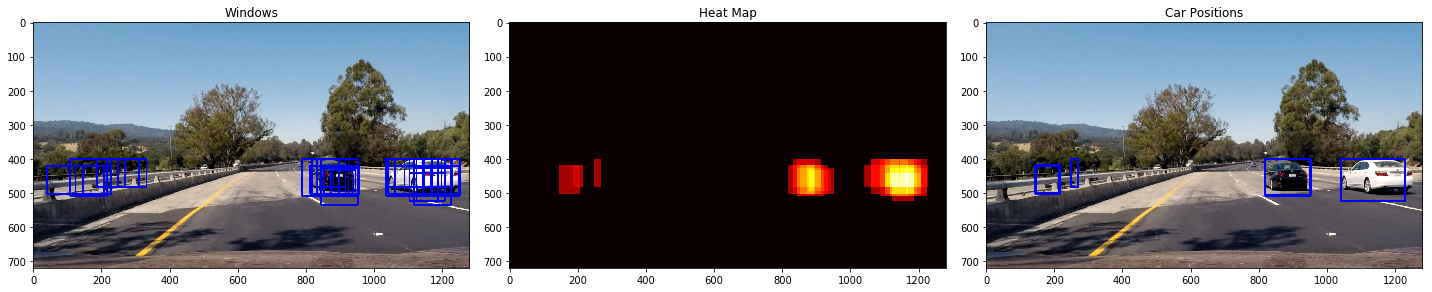

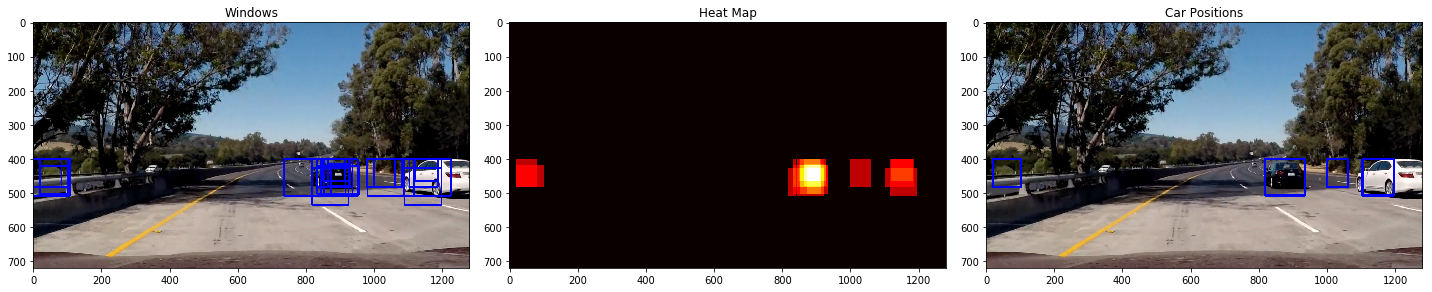

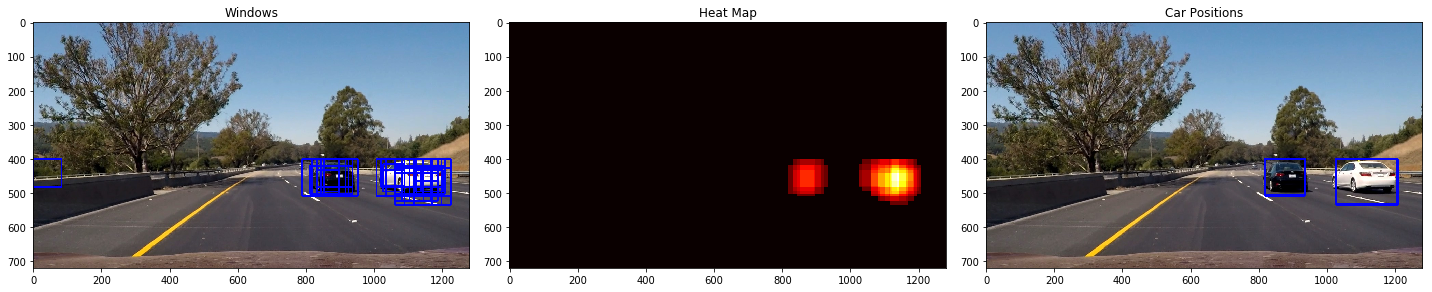

In [6]:
images = glob.glob('./test_images/*.jpg')

memory = deque(maxlen=1)

for img_name in images:
    image = mpimg.imread(img_name)
    
    out_img, heatmap, draw_img = pipeline(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    

    
    
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.imshow(out_img)
    plt.title('Windows')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()

## Use pipeline on video

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [15]:
def process_image(image):
    _, _, draw_img = pipeline(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    return draw_img

Detect vehicles in test video

In [11]:
memory = deque(maxlen=8)

project_output = 'test_video_result.mp4'
clip1 = VideoFileClip("test_video.mp4")#.subclip(0,2)
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|████████████████████████████████████████▉ | 38/39 [01:33<00:02,  2.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

Wall time: 1min 34s


Show the test video

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

Detect vehicles in project video

In [13]:
memory = deque(maxlen=8)

project_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,2)
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [52:45<00:02,  2.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 52min 46s


Show the project video

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))